In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

from PIL import Image, ImageFilter
from jaxinterp2d import interp2d
import scipy.io

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



## 1. Generate data + pretraining

In [2]:
f = scipy.io.loadmat('data/PU1_034_3/NEWLYFIXED_PU1_034_3.mat')

# These are the limits of the square region in the middle.
i1 = 57
i2 = 236
i3 = 55
i4 = 218
nx = i4-i3
ny = i2-i1

x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
x, y = np.meshgrid(x,y)

E_xx = np.zeros([50,ny,nx])
E_xy = np.zeros([50,ny,nx])
E_yy = np.zeros([50,ny,nx])
aux1 = np.zeros([50,291,275])
aux2 = np.zeros([50,291,275])
aux3 = np.zeros([50,291,275])
for i in range(50):
    aux1[i] = f['data_dic_save']['strains'][0,0][0,i][0]
    aux2[i] = f['data_dic_save']['strains'][0,0][0,i][1]
    aux3[i] = f['data_dic_save']['strains'][0,0][0,i][2]
    E_xx[i] = aux1[i][i1:i2, i3:i4]
    E_xy[i] = aux2[i][i1:i2, i3:i4]
    E_yy[i] = aux3[i][i1:i2, i3:i4]



F_data = pd.read_csv('data/PU1_034_3/PU1_034_3Data.csv')
F_data = F_data[F_data.SetName=='Equibiaxial']
F_data = F_data[F_data.Cycle=='2-Recover'].reset_index()
Force_x = jnp.flip(F_data['XForce_mN'].to_numpy().astype(float))
Force_y = jnp.flip(F_data['YForce_mN'].to_numpy().astype(float))
Force_x = (Force_x-Force_x[0])/Force_x[-1]*1000
Force_y = (Force_y-Force_y[0])/Force_y[-1]*1000


lmbx_hist = jnp.flip(F_data['XSize_um'].to_numpy())
lmby_hist = jnp.flip(F_data['YSize_um'].to_numpy())
lmbx_hist = lmbx_hist/lmbx_hist[0]
lmby_hist = lmby_hist/lmby_hist[0]


Force_x = Force_x[::2]
Force_y = Force_y[::2]
lmbx_hist = lmbx_hist[::2]
lmby_hist = lmby_hist[::2]
E_xx = E_xx[::2]
E_xy = E_xy[::2]
E_yy = E_yy[::2]

E_xx_plot = E_xx[::5]
E_xy_plot = E_xy[::5]
E_yy_plot = E_yy[::5]

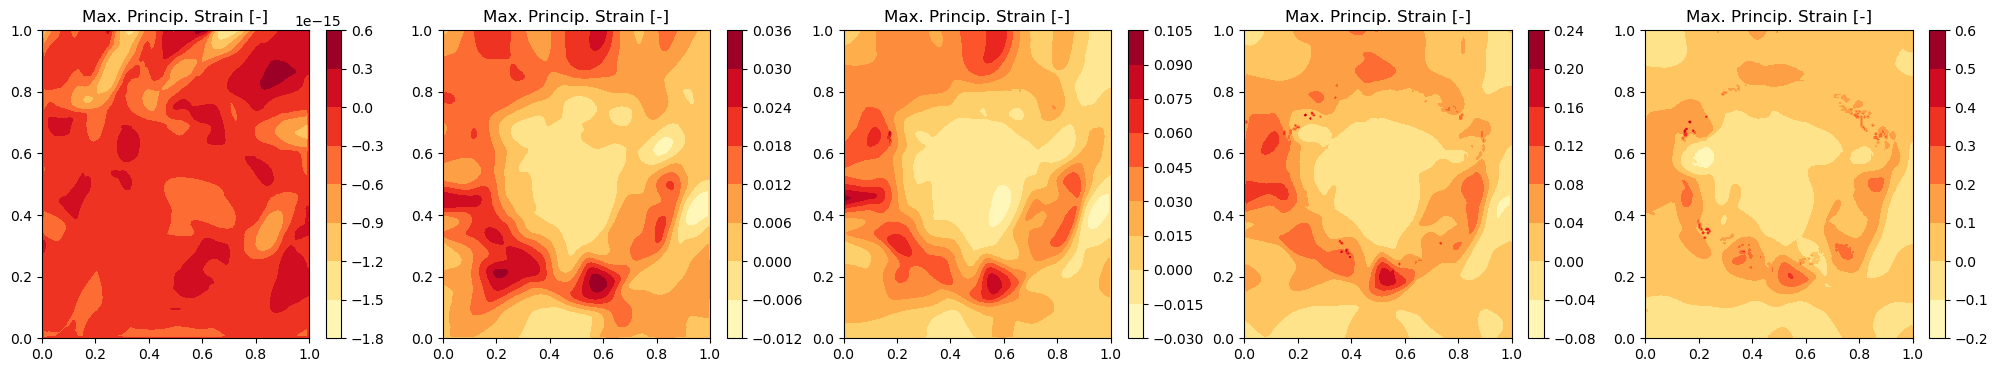

In [3]:
fig, ax = plt.subplots(1,len(E_xx_plot),figsize=(len(E_xx_plot)*5,4))
for i in range(len(E_xx_plot)):
    E = np.array([[E_xx_plot[i], E_xy_plot[i]], 
                  [E_xy_plot[i], E_yy_plot[i]]]).transpose([3,2,0,1])
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    cf = ax[i].contourf(x,y,E_11, cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[i])

    ax[i].set(title='Max. Princip. Strain [-]')

### Coords_2_strain NN

In [4]:
node_X = np.array([x.flatten(), y.flatten()]).T
inp2 = []
for i in range(len(E_xx)):
    aux = np.vstack([node_X[:,0], node_X[:,1], np.ones(len(node_X))*i, E_xx[i].flatten(), E_xy[i].flatten(), E_yy[i].flatten()]).T
    inp2.append(aux)
inp = np.array(inp2).reshape([-1,6]) #contains [X, Y, time, E_xx, E_xy, E_yy]

In [5]:
def E_fun2(F):
    F = F.reshape([2,2])
    E = 0.5*(F.T@F - jnp.eye(2))
    return E[0,0], E[0,1], E[1,1]

# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, E_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=
    F_pr = coords_2_strain_nn(inp, params)
    E_pr = jnp.array(vmap(E_fun2)(F_pr)).T
    return jnp.mean((E_pr-E_gt)**2)

n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])*0.5
nn_layers = [2*n_ff+1,20,20,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000, batch_size=1000)

it 1000, train loss = 4.630478e-03
it 2000, train loss = 3.096354e-03
it 3000, train loss = 2.228419e-03
it 4000, train loss = 1.759041e-03
it 5000, train loss = 1.261260e-03
it 6000, train loss = 1.322653e-03
it 7000, train loss = 1.052585e-03
it 8000, train loss = 1.034321e-03
it 9000, train loss = 9.384985e-04
it 10000, train loss = 8.088792e-04
it 11000, train loss = 9.036510e-04
it 12000, train loss = 6.860136e-04
it 13000, train loss = 7.765254e-04
it 14000, train loss = 8.611018e-04
it 15000, train loss = 9.066801e-04
it 16000, train loss = 7.288790e-04
it 17000, train loss = 5.946508e-04
it 18000, train loss = 7.422990e-04
it 19000, train loss = 6.471072e-04
it 20000, train loss = 6.268371e-04
it 21000, train loss = 8.338950e-04
it 22000, train loss = 6.141748e-04
it 23000, train loss = 6.992456e-04
it 24000, train loss = 6.157649e-04
it 25000, train loss = 6.397407e-04
it 26000, train loss = 6.302219e-04
it 27000, train loss = 6.661930e-04
it 28000, train loss = 6.366651e-04
i

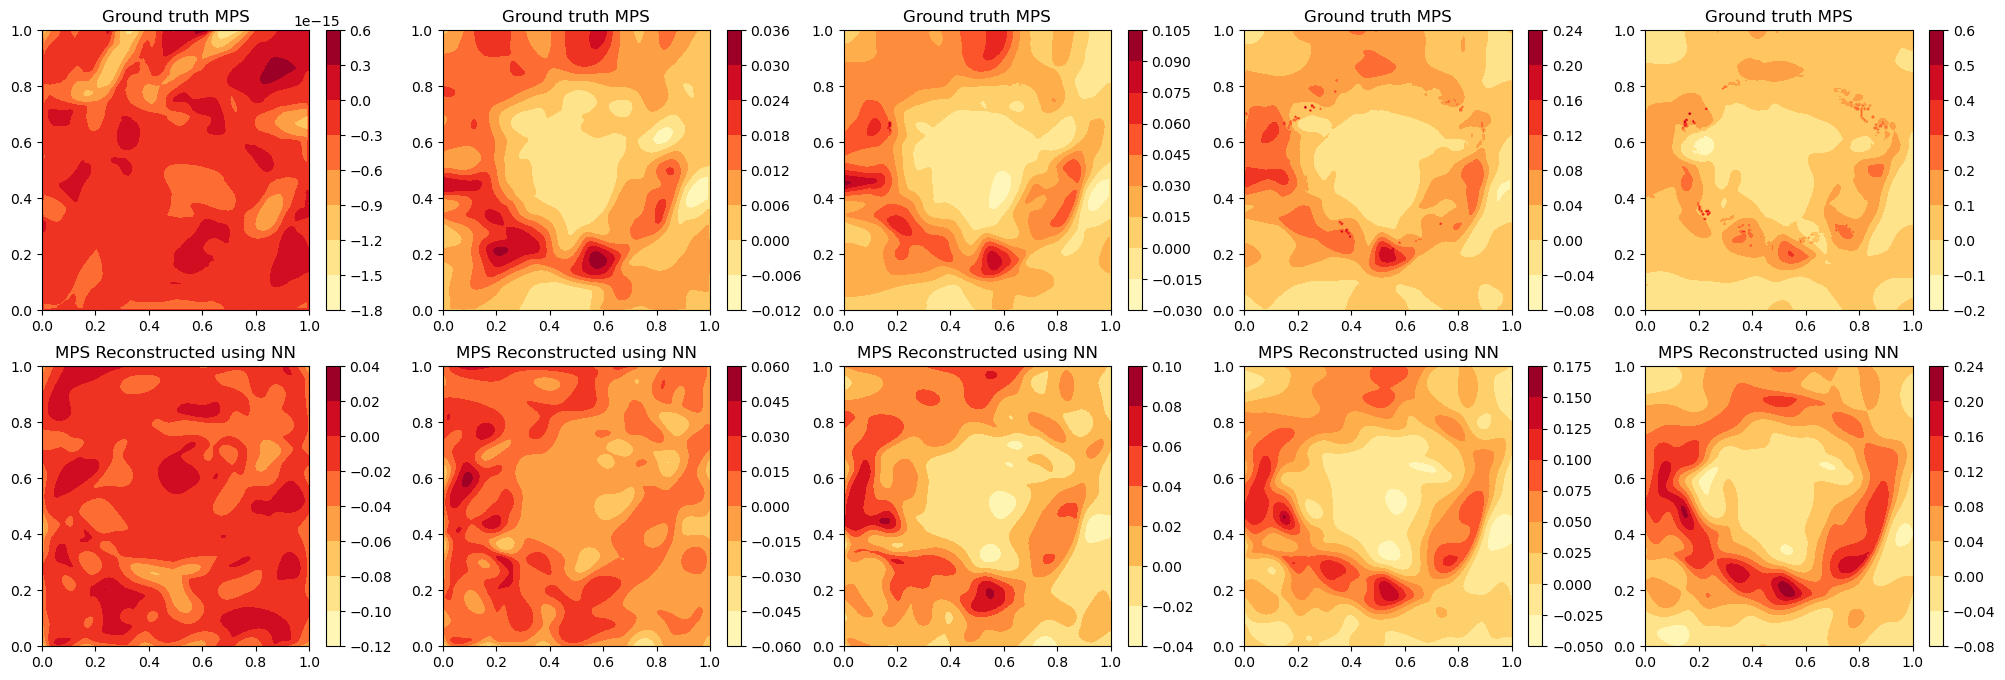

In [6]:
F_pr = coords_2_strain_nn(inp[:,:3], coord_2_strain_params)
E_pr = np.array(vmap(E_fun2)(F_pr))
E_pr = np.array([[E_pr[0,:], E_pr[1,:]], [E_pr[1,:], E_pr[2,:]]]).transpose([2,0,1])
evals, efuns = jnp.linalg.eigh(E_pr)
E_11, E_22 = evals.T
E_11 = E_11.reshape([25,179,163])
E_11_plot = E_11[::5]

fig, ax = plt.subplots(2,len(E_11_plot),figsize=(len(E_11_plot)*5,8))
for i in range(len(E_11_plot)):
    # pr
    cf = ax[1,i].contourf(x,y,E_11_plot[i], cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[1,i])
    ax[1,i].set(title='MPS Reconstructed using NN')


    # gt
    E_gt = np.array([[E_xx_plot[i], E_xy_plot[i]], 
                     [E_xy_plot[i], E_yy_plot[i]]]).transpose([3,2,0,1])
    evals, efuns = jnp.linalg.eigh(E_gt)
    E_11_gt, E_22_gt = evals.T
    cf = ax[0,i].contourf(x,y,E_11_gt, cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[0,i])
    ax[0,i].set(title='Ground truth MPS')


In [20]:
x_range = np.linspace(0,1,40)
rgt_bd_X = np.array([np.ones(40), x]).T
top_bd_X = np.array([x, np.ones(40)]).T
lft_bd_X = np.array([np.zeros(40), x]).T
bot_bd_X = np.array([x, np.zeros(40)]).T
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [21]:
E = np.array([[E_xx.flatten(), E_xy.flatten()], [E_xy.flatten(), E_yy.flatten()]])
C = 2*E + np.eye(2)[:,:,None]
evals, efuns = jnp.linalg.eigh(C.transpose([2,0,1]))
evals = np.sqrt(evals)
F = vmap(lambda eval1, efun1, eval2, efun2: eval1*jnp.outer(efun1, efun1) + eval2*jnp.outer(efun2, efun2))(evals[:,0], efuns[:,:,0], evals[:,1], efuns[:,:,1])

F_xx = F[:,0,0].reshape([25,163,179])
F_xy = F[:,0,1].reshape([25,163,179])
F_yx = F[:,1,0].reshape([25,163,179])
F_yy = F[:,1,1].reshape([25,163,179])

F_xx_mean = np.mean(F_xx.reshape([F_xx.shape[0], -1]), axis=1)
F_xy_mean = np.mean(F_xy.reshape([F_xx.shape[0], -1]), axis=1)
F_yx_mean = np.mean(F_yx.reshape([F_xx.shape[0], -1]), axis=1)
F_yy_mean = np.mean(F_yy.reshape([F_xx.shape[0], -1]), axis=1)

P_xx_mean = Force_x/len(rgt_bd_X-1) # num elems = num nodes - 1
P_yy_mean = Force_y/len(top_bd_X-1)
inputs = np.array([F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, P_xx_mean, P_yy_mean]).T

In [28]:
n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_stress(params, x, key):
    model = NODE_model_aniso(params)
    F_xx, F_xy, F_yx, F_yy, P_xx_gt, P_yy_gt = x.T
    P = eval_P_vmap(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
    return np.mean((P_xx_pr-P_xx_gt)**2+(P_yy_pr-P_yy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_stress, inputs, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 1.198835e+01
it 2000, train loss = 9.666015e+00
it 3000, train loss = 8.313688e+00
it 4000, train loss = 7.570278e+00
it 5000, train loss = 7.121984e+00
it 6000, train loss = 6.793842e+00
it 7000, train loss = 6.570799e+00
it 8000, train loss = 6.456343e+00
it 9000, train loss = 6.395999e+00
it 10000, train loss = 6.360611e+00
it 11000, train loss = 6.338290e+00
it 12000, train loss = 6.338845e+00
it 13000, train loss = 6.312257e+00
it 14000, train loss = 6.303988e+00
it 15000, train loss = 6.297498e+00
it 16000, train loss = 6.292284e+00
it 17000, train loss = 6.287959e+00
it 18000, train loss = 6.284513e+00
it 19000, train loss = 6.281200e+00
it 20000, train loss = 6.278470e+00


gt P_xx & P_yy:  [ 0.       0.       0.27583  0.17553  0.1003   0.27583  0.17553  0.17553  0.17553  0.27583  0.27583  0.62688  0.52658  0.90271  0.80241  1.07823  1.50451  1.78034  2.48245  3.63591  4.96489  6.82046  9.65396 13.61585 20.61184] [ 0.       0.17912  0.48618  0.25589  0.25589  0.48618  0.40942  0.56295  0.63971  0.56295  0.63971  0.8956   1.04913  0.97236  1.35619  1.68884  1.99591  2.55885  3.65916  4.45241  5.8086   7.72774 10.18424 14.38076 21.13613]
pr P_xx & P_yy:  [-0.       0.00012  0.00213  0.00876  0.022    0.05007  0.08766  0.16678  0.26117  0.39312  0.58744  0.80567  1.13111  1.54808  2.07413  2.68034  3.43638  4.33591  5.45371  6.62066  8.08503  9.68405 10.76199 12.1285  14.98927] [-0.       0.00019  0.00259  0.01013  0.02418  0.05458  0.0941   0.18     0.28236  0.42229  0.63228  0.86576  1.20829  1.63342  2.17144  2.78455  3.54862  4.45797  5.57483  6.73111  8.19029  9.76982 10.80376 12.17668 15.01757]


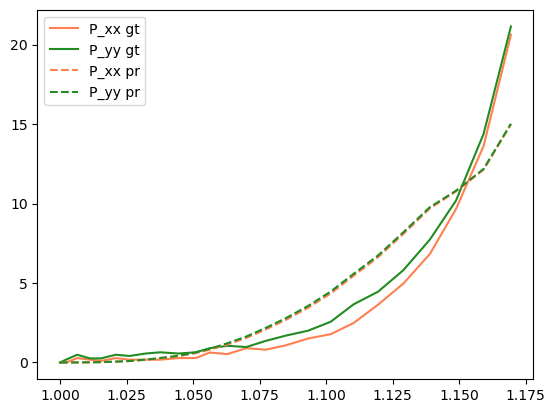

In [23]:
mymodel = NODE_model_aniso(node_params)
P = eval_P_vmap(F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, mymodel)
P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
print('gt P_xx & P_yy: ', P_xx_mean, P_yy_mean)
print('pr P_xx & P_yy: ', P_xx_pr, P_yy_pr)

fig, ax = plt.subplots()
ax.plot(lmbx_hist, P_xx_mean, '-', color='coral', label='P_xx gt')
ax.plot(lmbx_hist, P_yy_mean, '-', color='forestgreen', label='P_yy gt')
ax.plot(lmbx_hist, P_xx_pr, '--', color='coral', label='P_xx pr')
ax.plot(lmbx_hist, P_yy_pr, '--', color='forestgreen', label='P_yy pr')
ax.legend()

In [35]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 2.526244e-04
it 2000, train loss = 1.250367e-04
it 3000, train loss = 6.851334e-05
it 4000, train loss = 3.871148e-05
it 5000, train loss = 2.228220e-05


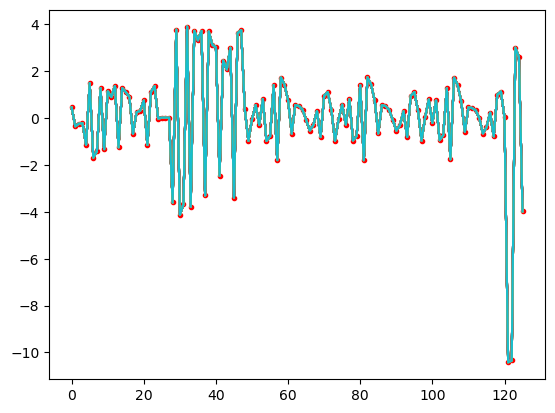

In [37]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [6]:
t_hist = np.arange(len(E_xx))
with open('params/murine_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, node_X, Force_x, Force_y, E_xx, E_xy, E_yy, bd_X, lmbx_hist, lmby_hist, t_hist], f)

## 2. Retrain

In [2]:
with open('params/murine_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, node_X, Force_x, Force_y, E_xx, E_xy, E_yy, bd_X, lmbx_hist, lmby_hist, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [3]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
    loss_Div = a1*(Div_x**2 + Div_y**2)

    def bd_forces_loss(_, t):
        F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
        Fx = Force_x[jnp.array(t, int)]
        Fy = Force_y[jnp.array(t, int)]
        return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    # loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    loss_F = 0.0
    
    return loss_Div + loss_F

lr = 1e-4
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([node_X, t_hist[-1]*np.ones_like(node_X[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [node_X, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 25000, print_freq=1000, batch_size=1000, metric_fns=[metric1, metric2])

with open('params/murine_post.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_X, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmbx_hist, lmby_hist], f)

it 1000, val loss = 1.199585e+02
it 2000, val loss = 6.793165e+01
it 3000, val loss = 3.993853e+01
it 4000, val loss = 2.414745e+01
it 5000, val loss = 1.507927e+01
it 6000, val loss = 1.001659e+01
it 7000, val loss = 7.039460e+00
it 8000, val loss = 5.045546e+00
it 9000, val loss = 3.741569e+00
it 10000, val loss = 2.905800e+00
it 11000, val loss = 2.290421e+00
it 12000, val loss = 1.896111e+00
it 13000, val loss = 1.646162e+00
it 14000, val loss = 1.494139e+00
it 15000, val loss = 1.448659e+00
it 16000, val loss = 1.427547e+00
it 17000, val loss = 1.438561e+00
it 18000, val loss = 1.431463e+00
it 19000, val loss = 1.409814e+00
it 20000, val loss = 1.395621e+00
it 21000, val loss = 1.409804e+00
it 22000, val loss = 1.410907e+00
it 23000, val loss = 1.425970e+00
it 24000, val loss = 1.428104e+00
it 25000, val loss = 1.420931e+00


## 3. Test

In [4]:
with open('params/murine_post.npy', 'rb') as f:
    coord_2_strain_params, node_X, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmbx_hist, lmby_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

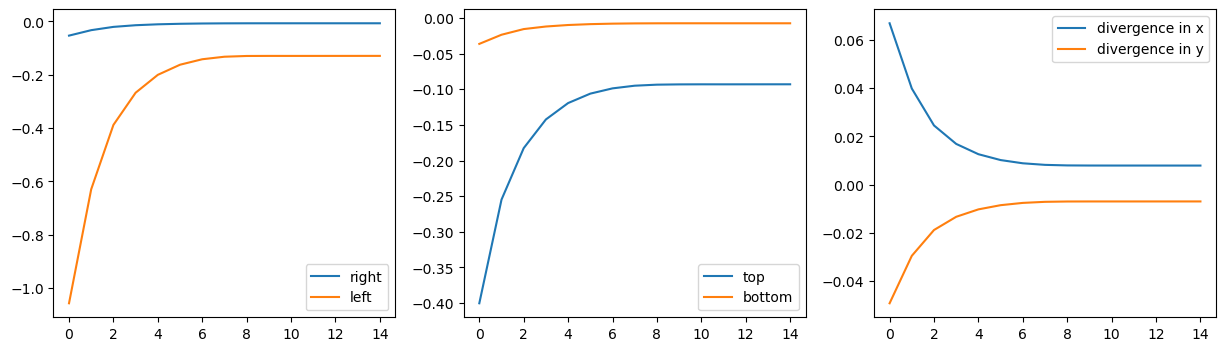

In [5]:
bd_forces = np.array([m[0] for m in metrics]).T
div = np.array([m[1] for m in metrics]).T

fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(bd_forces[0], label='right')
ax[0].plot(bd_forces[2], label='left')
# ax[0].axhline(Force_x[-1], linestyle='--')

ax[1].plot(bd_forces[1], label='top')
ax[1].plot(bd_forces[3], label='bottom')

ax[2].plot(div[0], label='divergence in x')
ax[2].plot(div[1], label='divergence in y')

ax[0].legend()
ax[1].legend()
ax[2].legend()

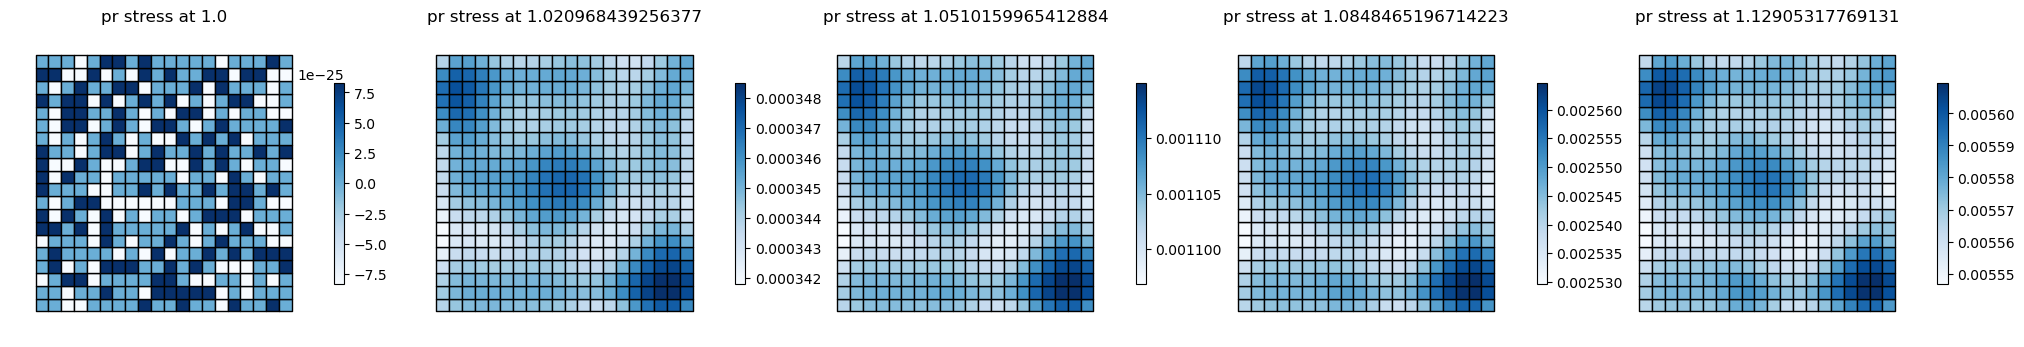

In [5]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)
Nx, Ny = 20, 20
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X = mesh.points[mesh.cells].mean(axis=1)


# Stiffness across the domain
fig, axes = plt.subplots(1,5,figsize=(25,4))
for lmbx, lmby, ax in zip(lmbx_hist[::5], lmby_hist[::5], axes.T):
    ugrad = jnp.array([[lmbx-1.0, 0.0], [0.0, lmby-1.0]])

    params_pr = ff_nn(elem_X, Lambda_params)

    c_elem_gt = []
    c_elem_pr = []
    for params_pr_i in params_pr:
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])
     
    plotmesh(mesh.cells, mesh.points, c_elem_pr, title='pr stress at {}'.format(str(lmbx)), ax=ax); 

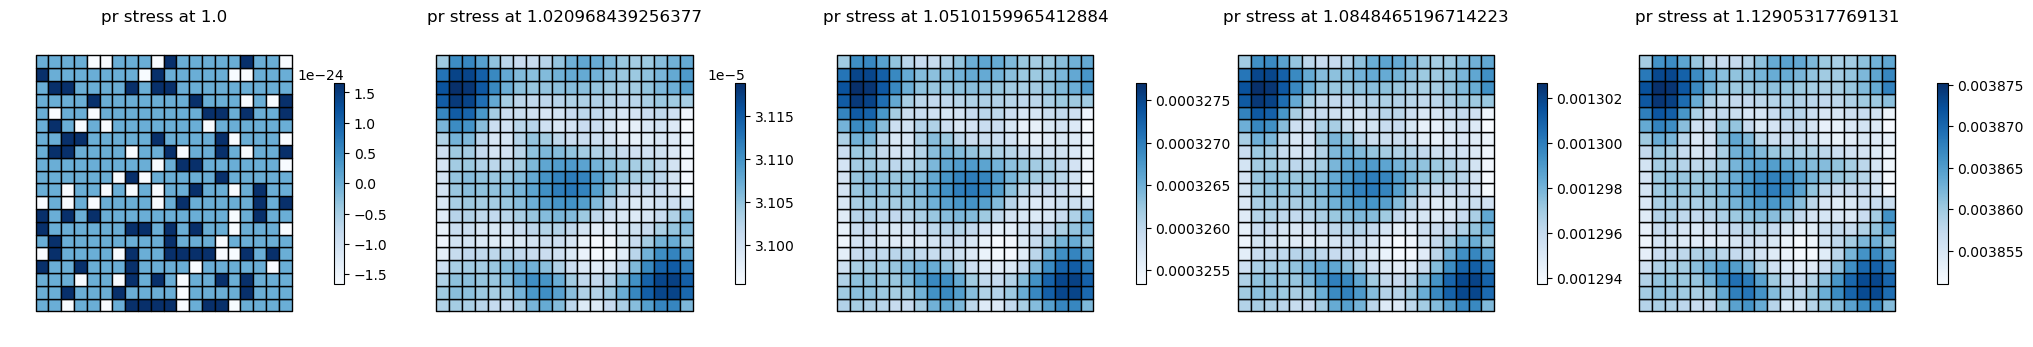

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)
Nx, Ny = 20, 20
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X = mesh.points[mesh.cells].mean(axis=1)


# Stiffness across the domain
fig, axes = plt.subplots(1,5,figsize=(25,4))
for lmbx, lmby, ax in zip(lmbx_hist[::5], lmby_hist[::5], axes.T):
    ugrad = jnp.array([[lmbx-1.0, 0.0], [0.0, lmby-1.0]])

    params_pr = ff_nn(elem_X, Lambda_params)

    c_elem_gt = []
    c_elem_pr = []
    for params_pr_i in params_pr:
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])
     
    plotmesh(mesh.cells, mesh.points, c_elem_pr, title='pr stress at {}'.format(str(lmbx)), ax=ax); 

In [7]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [8]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [15]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 20, 20
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


# lmb_hist = [1.05, 1.10, 1.15, 1.20]
lmb_hist = lmbx_hist[::5]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[02-27 20:01:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[02-27 20:01:01][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[02-27 20:01:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[02-27 20:01:01][DEBUG] jax_fem: Done pre-computations, took 0.10405302047729492 [s]
[02-27 20:01:01][INFO] jax_fem: Solving a problem with 400 cells, 441x2 = 882 dofs.
[02-27 20:01:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[02-27 20:01:01][DEBUG] jax_fem: Start timing
[02-27 20:01:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[02-27 20:01:02][DEBUG] jax_fem: Function split_and_compute_cell took 1.2399 seconds
[02-27 20:01:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[02-27 20:01:02][DEBUG] jax_fem: Linear guess solve...
[02-27 20:01:02][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[02-27 20:01:02][DEBUG] jax_fem: PETSc

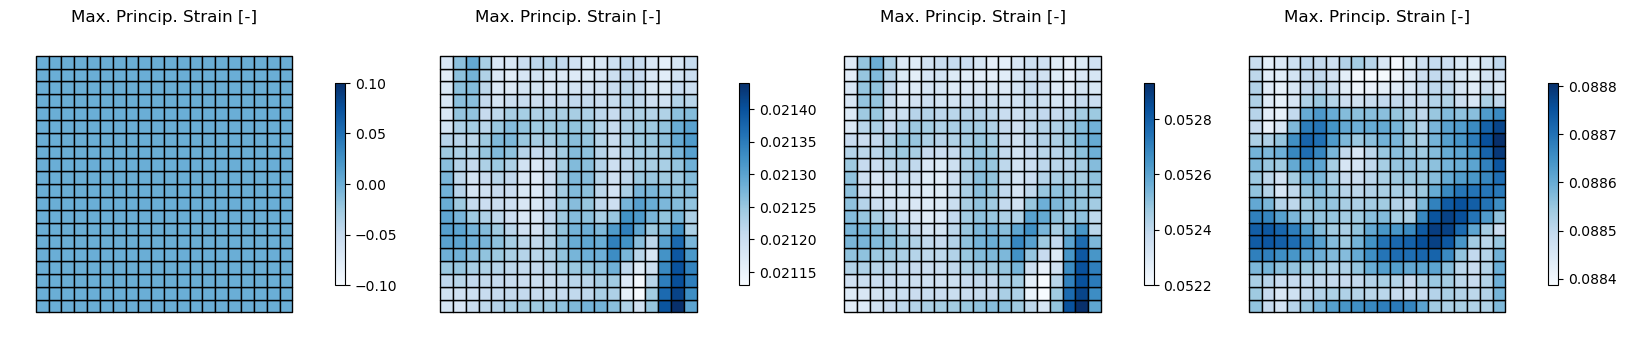

In [16]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 